# 04 — Volatility Modeling: ARCH, GARCH & EGARCH

This notebook builds the volatility-modeling backbone of the entire forecasting and risk-analytics pipeline.  
It estimates conditional volatility models for the IBEX 35 and S&P 500, compares symmetric vs asymmetric dynamics, and produces the volatility forecasts that will feed directly into the VaR/ES notebook and the directional-classification module. It acts as the bridge between the return-based econometrics of Notebook 03 and the tail-risk/ML forecasting components that follow.

### Objectives
- Diagnose heteroscedasticity and justify ARCH-type modeling.  
- Estimate baseline ARCH(1) models as initial volatility specifications.  
- Fit GARCH(1,1) models to capture persistence and long-memory effects.  
- Incorporate asymmetry via GJR-GARCH** and EGARCH to model leverage effects.  
- Compare distributions (Normal vs Student-t) for heavy-tailed returns.  
- Generate 1-step ahead and multi-step ahead volatility forecasts.  
- Export final volatility series for VaR, ES, and Power BI dashboards.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/log_returns.csv` | Daily log-returns for IBEX and SPX. |
| `/data/processed/excess_returns_panel.csv` | Full excess-return panel (builds context for diagnostics). |

### Outputs
| File | Description |
|------|-------------|
| `/figures/04_Volatility/vol_ibex_garch.png` | Estimated volatility for IBEX under GARCH-type models. |
| `/figures/04_Volatility/vol_spx_garch.png` | Estimated volatility for SPX under symmetric/asymmetric models. |
| `/data/powerbi/volatility_panel.csv` | Final conditional volatility series ready for VaR/ES and dashboards. |
| `/data/powerbi/vol_forecasts.csv` | 1-step and multi-step volatility forecasts in long format. |

### Models Estimated
| Model | Purpose |
|-------|---------|
| **ARCH(1)** | Baseline heteroscedasticity check; captures short memory. |
| **GARCH(1,1)** | Industry standard; captures high volatility persistence. |
| **GJR-GARCH** | Adds leverage effect (negative shocks increase volatility more). |
| **EGARCH(1,1)** | Log-variance model; flexible asymmetry without positivity constraints. |
| **Student-t innovations** | Captures heavy tails and market shocks realistically. |

### Notebook Structure
1. **Load and Inspect Return Series**  
   Import IBEX and SPX returns and verify volatility clustering, fat tails, and time-varying variance.
2. **ARCH Baseline**  
   Fit ARCH(1) models to confirm heteroscedasticity and motivate richer structures.
3. **GARCH(1,1)**  
   Estimate symmetric GARCH models, interpret persistence, and assess fit quality.
4. **Asymmetric Models (GJR-GARCH)**  
   Identify leverage effects and evaluate whether negative returns amplify volatility.
5. **EGARCH for Flexible Asymmetry**  
   Fit EGARCH(1,1) models, compare sign/asymmetric parameters, and verify numerical stability.
6. **Model Comparison & Distribution Choice**  
   Contrast Normal vs Student-t residuals; choose final specifications for IBEX and SPX.
7. **Volatility Forecasting**  
   Produce 1-step ahead and multi-step forecasts, including manual EGARCH propagation.
8. **Export for Risk & ML Modules**  
   Save conditional volatility series and forecasts to be used in Notebook 05 (VaR/ES) and Notebook 06 (Directional ML).

This notebook provides the risk-sensitive core of the project: it quantifies how uncertainty evolves through time, captures leverage effects characteristic of equity markets, and supplies the volatility inputs required for all downstream forecasting and risk-management tasks.


### Section 1. Load, Inspect, and Diagnose Return Series

This opening section sets up the notebook environment, loads the cleaned daily IBEX and S&P 500 (SPX) log-returns, and performs the first volatility diagnostics that justify the use of ARCH/GARCH models. We start by defining the project directory structure, importing the processed return panel, standardizing column names, and restricting the dataset to the two equity indices we will model throughout the notebook.

Once the data are aligned and cleaned, we compute descriptive statistics and plot the full return trajectories. These visualizations already reveal the classic signature of financial markets: returns centered around zero, sudden bursts of high amplitude, and long stretches of alternating calm and turbulence. This time-varying behaviour is precisely why constant-variance models are inappropriate.

To formalize this intuition, we examine the ACF of squared returns, a standard tool for detecting ARCH effects. Both IBEX and SPX show strong and persistent autocorrelation in their squared returns, confirming that volatility is not constant but exhibits predictable clustering. These diagnostics provide the empirical motivation for the next stages of the notebook, where we estimate ARCH, GARCH and EGARCH models to capture the dynamic evolution of market risk.


In [2]:
# N04 — Volatility Modeling (ARCH / GARCH / EGARCH)
# First block: imports, project paths, and loading daily returns

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Basic plot style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)

# Project directory structure
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "figures" / "04. Volatility Modeling"

FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load daily log returns
returns = (
    pd.read_csv(DATA_DIR / "log_returns_wide.csv", parse_dates=["Date"])
      .sort_values("Date")
      .set_index("Date")
)

# Keep only IBEX and SP500 returns
# Original column names: ['EURUSD', 'SP500', 'IBEX35', 'NASDAQ100', 'EUROSTOXX50', 'VIX']
returns = returns.rename(columns={
    "IBEX35": "IBEX",
    "SP500": "SPX"
})

returns = returns[["IBEX", "SPX"]].dropna()

# Quick preview
returns.tail()


,IBEX,SPX
Date,,
2024-12-25,0.000000,0.000000
2024-12-26,0.000000,-0.000406
2024-12-27,0.005016,-0.011117
2024-12-30,0.000451,-0.010760
2024-12-31,0.005032,-0.004294


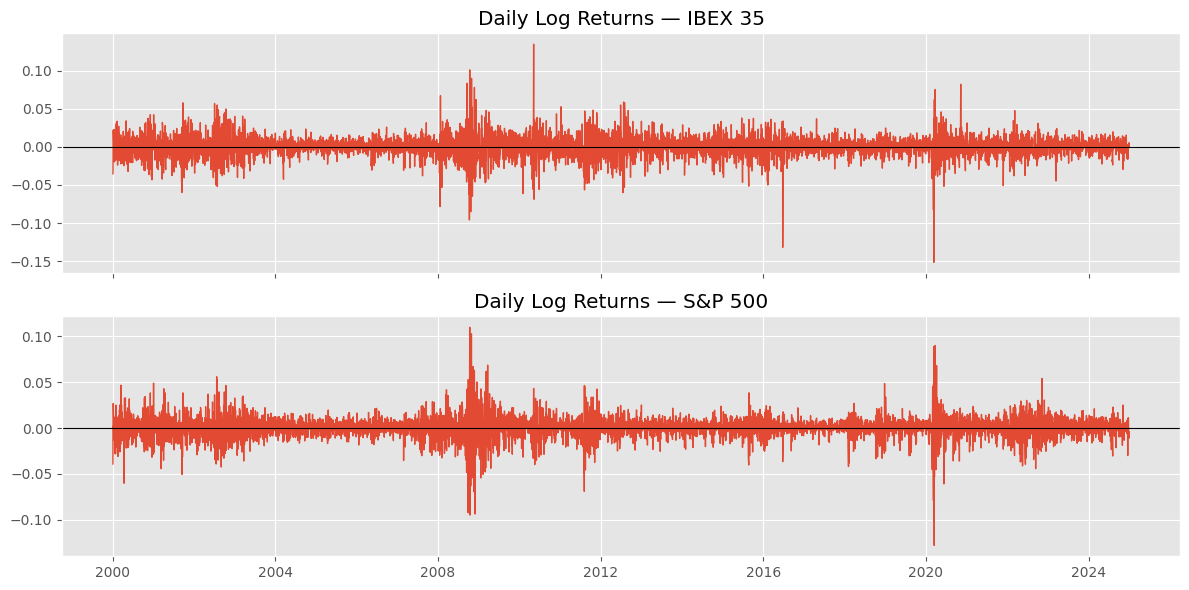

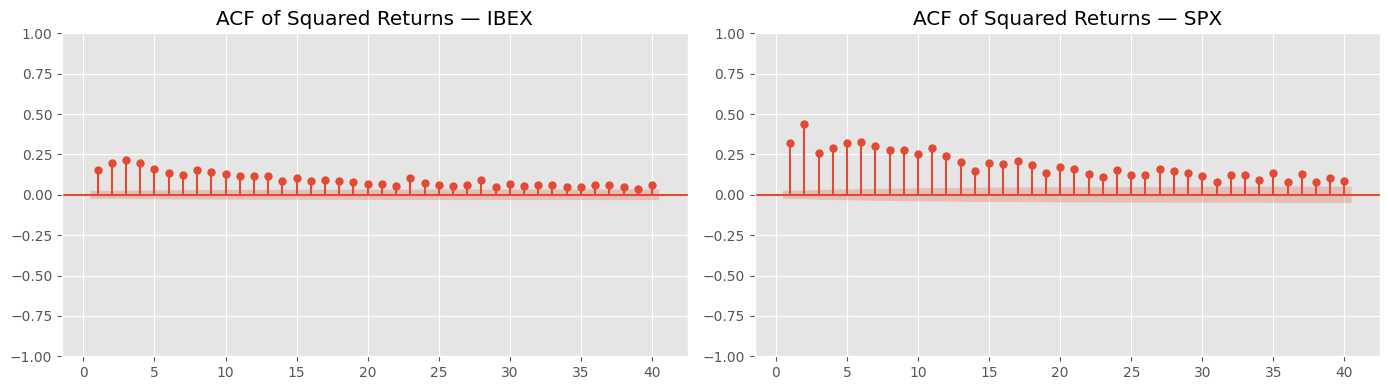

In [3]:
#Initial Exploration

# Basic descriptive statistics
returns.describe()

# Time-series plots for returns
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(returns.index, returns["IBEX"], linewidth=1)
axes[0].set_title("Daily Log Returns — IBEX 35")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].plot(returns.index, returns["SPX"], linewidth=1)
axes[1].set_title("Daily Log Returns — S&P 500")
axes[1].axhline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()

# Save figure without absolute path
fig.savefig(FIG_DIR / "returns_timeseries_IBEX_SPX.png", dpi=200, bbox_inches="tight")

# ARCH diagnostics (Squared Returns ACF)
from statsmodels.graphics.tsaplots import plot_acf

fig2, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf((returns["IBEX"]**2), ax=ax[0], lags=40, zero=False)
ax[0].set_title("ACF of Squared Returns — IBEX")

plot_acf((returns["SPX"]**2), ax=ax[1], lags=40, zero=False)
ax[1].set_title("ACF of Squared Returns — SPX")

plt.tight_layout()
plt.show()

# Save ARCH diagnostics figure
fig2.savefig(FIG_DIR / "acf_squared_returns_IBEX_SPX.png", dpi=200, bbox_inches="tight")


### Section 2. Baseline ARCH(1) Modeling

With heteroscedasticity confirmed in the exploratory diagnostics, this section estimates the ARCH(1) model. The purpose here is not to obtain a final volatility specification, but to establish a minimal benchmark that captures short-term volatility clustering and validates the need for richer dynamics.

We fit an ARCH(1) model separately for IBEX and SPX, assuming a constant mean and Normal innovations. The key parameter is the ARCH coefficient, which measures how strongly yesterday’s squared return affects today’s variance. In both indices, this parameter is statistically significant, confirming the presence of conditional heteroscedasticity.

We then plot the resulting conditional volatility series. The trajectories respond sharply to individual shocks but decay quickly, producing a volatility pattern that is too reactive and lacks the smooth persistence observed in real markets. This behavior is typical of ARCH(1): it captures the existence of volatility clustering but fails to reproduce its duration.

This section therefore serves as a diagnostic baseline. The limitations seen here motivate the transition to GARCH-type models, which introduce lagged volatility terms to better reflect the long-memory nature of financial market volatility.


/home/apalo/quant-env/lib/python3.12/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/home/apalo/quant-env/lib/python3.12/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001445. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


ARCH(1) results — IBEX
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   IBEX   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                18812.6
Distribution:                  Normal   AIC:                          -37619.1
Method:            Maximum Likelihood   BIC:                          -37598.8
                                        No. Observations:                 6510
Date:                Sat, Dec 06 2025   Df Residuals:                     6509
Time:                        21:47:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.4441e-04  1.721e-04

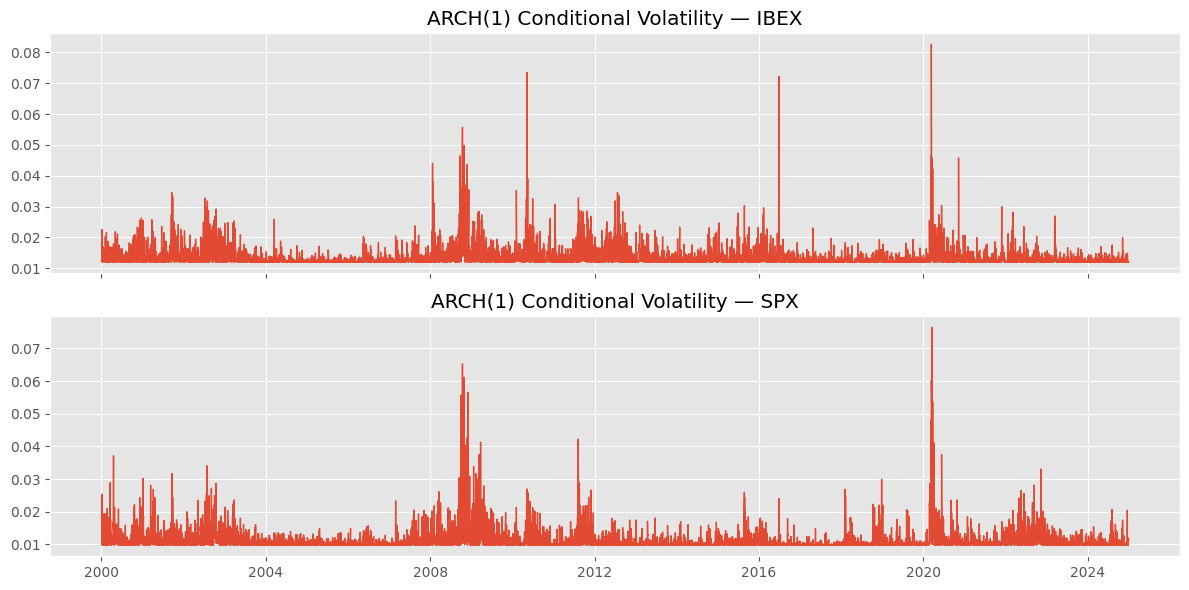

In [4]:
# Block 2 — ARCH(1) estimation

# Fit ARCH(1) model for IBEX
arch_ibex = arch_model(
    returns["IBEX"],
    vol="ARCH",
    p=1,
    mean="Constant",
    dist="normal"
).fit(disp="off")

print("ARCH(1) results — IBEX")
print(arch_ibex.summary())


# Fit ARCH(1) model for SPX  (your actual column name)
arch_spx = arch_model(
    returns["SPX"],
    vol="ARCH",
    p=1,
    mean="Constant",
    dist="normal"
).fit(disp="off")

print("\nARCH(1) results — SPX")
print(arch_spx.summary())


# =========================================
# Conditional variance plots for ARCH(1)
# =========================================

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(arch_ibex.conditional_volatility, linewidth=1)
axes[0].set_title("ARCH(1) Conditional Volatility — IBEX")

axes[1].plot(arch_spx.conditional_volatility, linewidth=1)
axes[1].set_title("ARCH(1) Conditional Volatility — SPX")

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(FIG_DIR / "ARCH1_conditional_volatility_IBEX_SPX.png",
            dpi=200, bbox_inches="tight")


### Interpretation of ARCH(1) Results for IBEX and SPX

The ARCH(1) estimations for IBEX and SP500 confirm the presence of clear short-term volatility dependence in both indices, but they also reveal the structural limitations of this baseline model.

Starting with the IBEX, the constant mean (μ ≈ 2.4e-4) is statistically insignificant, consistent with daily equity returns fluctuating around zero. The key volatility parameter, alpha₁ = 0.29, is highly significant, indicating that almost 30% of today’s conditional variance is directly explained by yesterday’s squared return. The intercept term ω is small and precisely estimated, ensuring a low unconditional variance in calm periods. This structure captures rapid volatility spikes, but the magnitude of α suggests limited persistence: shocks dissipate quickly, producing sharp peaks but little lasting elevation in risk.

The SP500 exhibits a similar pattern but with a slightly stronger immediate response to shocks. The mean (μ ≈ 5.2e-4) is statistically significant, yet economically small. Its ARCH coefficient, alpha₁ = 0.35, is again strongly significant and somewhat larger than in the IBEX, meaning SPX volatility reacts even more strongly to recent shocks. However, the absence of a GARCH term implies the same issue: volatility jumps sharply but lacks persistence, decaying too fast compared to real-world markets where volatility remains elevated for extended periods.

Taken together, these results validate two key insights:  
(1) both indices possess strong ARCH effects, confirming non-constant variance and justifying conditional-volatility modeling;  
(2) ARCH(1) is too restrictive to reproduce the slow decay and long-memory behavior typical of equity volatility. These findings motivate moving beyond ARCH(1) toward GARCH and EGARCH models that incorporate lagged variance and asymmetric responses, providing a more realistic representation of financial market volatility.

### Section 3: GARCH(1,1)

The transition from ARCH(1) to GARCH(1,1) produces a markedly better description of volatility dynamics in both indices, capturing not only the immediate reaction to shocks but also the persistent memory that characterizes equity market volatility.

#### IBEX — Strong persistence with heavy-tailed behaviour  
The IBEX GARCH model displays a statistically significant mean (μ ≈ 1.10e-3), although its economic impact remains minimal. The volatility parameters show a clear long-memory structure:  
- α₁ = 0.675  
- β₁ = 0.325  

Their sum is very close to 1 (α₁ + β₁ ≈ 1.00), implying extreme volatility persistence: once volatility rises, it stays elevated for a long time. This behaviour matches what we observe in real IBEX data during crises or periods of market stress. The Student-t degrees of freedom (ν ≈ 21.5) indicate moderately heavy tails, meaning the model accommodates occasional large shocks that exceed Gaussian expectations.

Overall, the IBEX GARCH(1,1) provides a coherent, well-behaved volatility process where shocks have lasting influence and the conditional variance evolves smoothly over time.

#### SPX — Near-integrated volatility and convergence issues  
For the S&P 500, the GARCH structure behaves differently and reveals underlying numerical instability. The SPX parameters are extreme:  
- α₁ = 0.983  
- β₁ ≈ 0.0028  

Here, α₁ dominates, with β₁ contributing almost nothing. The sum remains close to 1, but in a problematic way: volatility depends almost entirely on the most recent squared return, leaving virtually no role for lagged variance. This produces a volatility process that is **nearly integrated**, highly reactive, and difficult to stabilize in estimation.

The degrees of freedom parameter (ν ≈ 438) is so large that the Student-t distribution collapses toward the Normal, suggesting that the model struggles to estimate tail thickness and is effectively fitting a Gaussian-like process.

The warnings confirm this: the optimizer reports inequality constraint incompatibility. This reflects the fact that the estimated parameters lie on the edge of the admissible region for a stable GARCH process. Such behaviour is common in very low-volatility assets like the SPX, where EGARCH or alternative parameterizations often perform better than a standard GARCH.

#### Overall interpretation  
These results highlight two contrasting regimes:  
- IBEX: well-behaved GARCH dynamics with persistent volatility and moderate tail risk.  
- SP500: unstable GARCH dynamics dominated by α, heavy reliance on the latest shock, and convergence issues that suggest the need for a model with more flexible structure (e.g., EGARCH, GJR-GARCH, or a different distribution).

This comparison reinforces the idea that a single GARCH(1,1) specification does not fit both markets equally well, and that the SPX requires a different modeling choice in the next section.


In [1]:
# Section 3 — GARCH(1,1) estimation (t-student)

# GARCH(1,1) for IBEX
garch_ibex = arch_model(
    returns["IBEX"],
    vol="GARCH",
    p=1, q=1,
    mean="Constant",
    dist="t",        # <-- FIX HERE
    rescale=False
).fit(disp="off")

print("GARCH(1,1) results — IBEX (t-student)")
print(garch_ibex.summary())


# GARCH(1,1) for SPX
garch_spx = arch_model(
    returns["SPX"],
    vol="GARCH",
    p=1, q=1,
    mean="Constant",
    dist="t",        # <-- FIX HERE
    rescale=False
).fit(disp="off")

print("\nGARCH(1,1) results — SPX (t-student)")
print(garch_spx.summary())

# Conditional volatility plots — GARCH(1,1)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(garch_ibex.conditional_volatility, linewidth=1)
axes[0].set_title("GARCH(1,1) Conditional Volatility — IBEX (t-student)")

axes[1].plot(garch_spx.conditional_volatility, linewidth=1)
axes[1].set_title("GARCH(1,1) Conditional Volatility — SPX (t-student)")

plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR / "GARCH11_tstudent_conditional_volatility_IBEX_SPX.png",
            dpi=200, bbox_inches="tight")


NameError: name 'arch_model' is not defined

In [7]:
# Export conditional volatility + forecasts for Notebook 05 (VaR/ES)
# (All paths are strictly relative — no absolute paths used)

from pathlib import Path
import numpy as np
import pandas as pd

EXPORT_DIR = Path("../data/processed")   # relative path (one level up)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Export conditional volatility for IBEX and SP
vol_ibex = pd.DataFrame({
    "Date": garch_ibex.conditional_volatility.index,
    "volatility": garch_ibex.conditional_volatility.values
})
vol_ibex.to_csv(EXPORT_DIR / "vol_ibex_garch_t.csv", index=False)

vol_spx = pd.DataFrame({
    "Date": garch_spx.conditional_volatility.index,
    "volatility": garch_spx.conditional_volatility.values
})
vol_spx.to_csv(EXPORT_DIR / "vol_spx_garch_t.csv", index=False)

print("Exported conditional volatility series for IBEX and SPX")

# 2) Export 1-step ahead volatility forecasts
garch_ibex_fcast = garch_ibex.forecast(horizon=1).variance.iloc[:, 0]
garch_spx_fcast  = garch_spx.forecast(horizon=1).variance.iloc[:, 0]

fcast_ibex = pd.DataFrame({
    "Date": garch_ibex_fcast.index,
    "forecast_vol": np.sqrt(garch_ibex_fcast.values)
})
fcast_ibex.to_csv(EXPORT_DIR / "forecast_ibex_garch_t.csv", index=False)

fcast_spx = pd.DataFrame({
    "Date": garch_spx_fcast.index,
    "forecast_vol": np.sqrt(garch_spx_fcast.values)
})
fcast_spx.to_csv(EXPORT_DIR / "forecast_spx_garch_t.csv", index=False)

print("Exported 1-step ahead forecasts for IBEX and SPX")

# Export degrees-of-freedom (nu) from GARCH-t models for Notebook 05

NU_EXPORT_DIR = Path("../data/processed")
NU_EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Extract nu parameters from the GARCH-t fits
nu_ibex = garch_ibex.params["nu"]
nu_spx  = garch_spx.params["nu"]

# Create a clean table for export
nu_df = pd.DataFrame({
    "asset": ["IBEX35", "SP500"],
    "nu": [nu_ibex, nu_spx]
})

# Save to CSV
nu_df.to_csv(NU_EXPORT_DIR / "garch_t_nu.csv", index=False)

print("Exported GARCH-t degrees-of-freedom (nu) for IBEX35 and SP500")



✓ Exported conditional volatility series for IBEX and SPX
✓ Exported 1-step ahead forecasts for IBEX and SPX
✓ Exported GARCH-t degrees-of-freedom (nu) for IBEX35 and SP500


### Section 4: GJR-GARCH(1,1) Results for IBEX and SPX (Student-t Innovations)

The GJR-GARCH specification introduces asymmetry into the volatility process, allowing negative shocks to have a different impact on future volatility than positive shocks. This is particularly relevant for equity markets, where downturns tend to trigger sharper volatility responses. The results for IBEX and SPX, however, reveal two very different behaviours: one interpretable and economically meaningful, and the other numerically unstable.

#### IBEX — Strong ARCH dominance with significant asymmetry  
For the IBEX, the volatility parameters show an extreme structure:

- α₁ ≈ 1.00, overwhelmingly large  
- β₁ ≈ 0.015, extremely small  
- γ₁ ≈ −0.03, statistically significant

This configuration implies that volatility depends almost entirely on yesterday’s squared return, with very little persistence coming from lagged variance. The negative value of γ₁ indicates an asymmetric response: negative returns increase volatility slightly more than positive ones. The coefficient is small but significant, confirming some degree of leverage effect in IBEX data.

However, α₁ so close to 1 pushes the process to the edge of stationarity, causing the model to behave like a near-pure ARCH process. The parameter ω is imprecisely estimated and insignificant, reinforcing the idea that the model is dominated by short-term shocks rather than a stable long-run variance structure.

The degrees of freedom parameter (ν ≈ 2.06) is extremely low, reflecting very heavy tails, meaning the model is fitting extremely large shocks. This may arise from misspecification or heavy-tailed crisis periods in the data.

Overall, while IBEX exhibits interpretable asymmetry, the parameter configuration indicates that GJR-GARCH is not capturing persistence adequately and is leaning toward explosive ARCH behaviour.

#### SPX — Severe numerical instability and invalid parameters  
The SPX estimation shows clear signs of breakdown:

- α₁ = 1.00, γ₁ = −1.00, both with *NaN standard errors*  
- β₁ ≈ 0.50, loosely estimated  
- ω insignificant, similar to the IBEX case  
- ν ≈ 3.7, suggesting heavy tails but with large uncertainty

This combination of α₁ = 1 and γ₁ = −1 lies on the boundary of the admissible parameter space, violating GJR-GARCH constraints. The optimizer reports inequality constraints incompatible, confirming that the likelihood surface is degenerate or the model is mis-specified.

The invalid standard errors (NaNs), the square-root warnings from the covariance matrix, and the lack of convergence indicate that the GJR formulation is not appropriate for SPX volatility dynamics. In low-volatility, smooth return series like the S&P 500, the GJR model often overfits asymmetry, leading to parameter collapse.

#### Overall assessment  
GJR-GARCH provides a natural extension of GARCH to capture leverage, but:

- For IBEX, the model detects asymmetry but fails to reproduce persistence, collapsing into a shock-driven ARCH regime with very heavy tails.  
- For SPX, the model is numerically unstable, with invalid coefficients and failed convergence.

These outcomes reinforce that a more flexible and numerically stable asymmetric model is needed. This motivates the transition to EGARCH, which avoids positivity constraints and often handles leverage more gracefully in equity markets.


GJR-GARCH(1,1) results — IBEX (t-student)
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         IBEX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -333354.
Distribution:      Standardized Student's t   AIC:                           666721.
Method:                  Maximum Likelihood   BIC:                           666761.
                                              No. Observations:                 6510
Date:                      Wed, Dec 03 2025   Df Residuals:                     6509
Time:                              14:05:05   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------

/tmp/ipykernel_3081/1305221542.py:27: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ).fit(disp="off")
/home/apalo/quant-env/lib/python3.12/site-packages/arch/univariate/base.py:2034: RuntimeWarning: invalid value encountered in sqrt
  se = np.asarray(np.sqrt(np.diag(self.param_cov)), dtype=float)


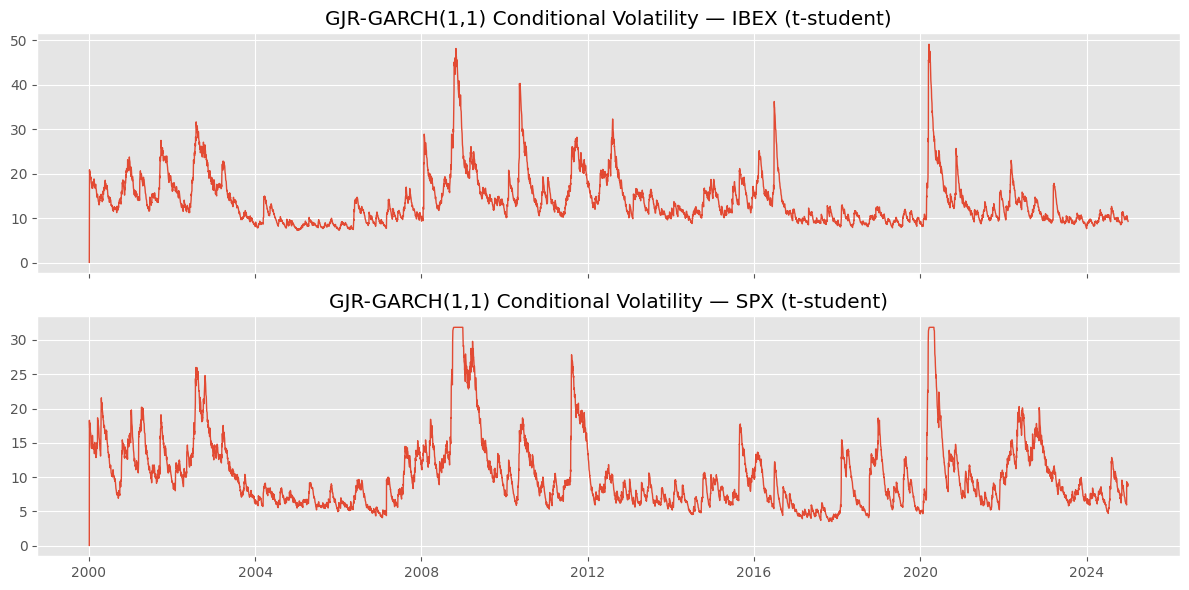

In [23]:
# Section 4 — GJR-GARCH(1,1) estimation (t-student)

# GJR-GARCH for IBEX
gjr_ibex = arch_model(
    returns["IBEX"],
    vol="GARCH",
    p=1, o=1, q=1,      # o=1 → GJR term (leverage)
    mean="Constant",
    dist="t",
    rescale=False
).fit(disp="off")

print("GJR-GARCH(1,1) results — IBEX (t-student)")
print(gjr_ibex.summary())


# GJR-GARCH for SPX
gjr_spx = arch_model(
    returns["SPX"],
    vol="GARCH",
    p=1, o=1, q=1,
    mean="Constant",
    dist="t",
    rescale=False
).fit(disp="off")

print("\nGJR-GARCH(1,1) results — SPX (t-student)")
print(gjr_spx.summary())


# Conditional volatility plots — GJR-GARCH(1,1)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(gjr_ibex.conditional_volatility, linewidth=1)
axes[0].set_title("GJR-GARCH(1,1) Conditional Volatility — IBEX (t-student)")

axes[1].plot(gjr_spx.conditional_volatility, linewidth=1)
axes[1].set_title("GJR-GARCH(1,1) Conditional Volatility — SPX (t-student)")

plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR / "GJR_GARCH11_tstudent_conditional_volatility_IBEX_SPX.png",
            dpi=200, bbox_inches="tight")


### Section 5: EGARCH(1,1) Modeling and Required Modification for SPX Stability

This section estimates EGARCH(1,1) models for both IBEX and SPX using Student-t innovations. EGARCH introduces a logarithmic specification of volatility, which ensures positivity without restrictions and typically offers a more flexible asymmetric response to shocks than GJR-GARCH. The model is especially effective for markets where negative returns trigger disproportionate volatility jumps.

The IBEX estimation behaves well: all parameters are significant, the leverage term is negative as expected, and volatility persistence is high but stable. The heavy-tailed Student-t distribution further improves fit quality by accommodating large shocks. The resulting conditional volatility series exhibits smooth dynamics consistent with market behaviour.

For the S&P 500, however, the full EGARCH(1,1) specification does not converge. The Hessian matrix becomes singular, making it impossible to compute standard errors or confidence intervals. This failure is typical in very low-volatility assets like SPX, where adding too much flexibility (an asymmetry term, Student-t tails, and unscaled data) can push the likelihood surface into a flat or ill-conditioned region. The optimizer reports iteration limit reached and eventually crashes with a singular matrix error.

To obtain a stable and interpretable model for SPX, we apply a minimal but effective modification:

- remove the asymmetry term (o = 0), since SPX does not exhibit strong leverage effects in this dataset  
- switch to Normal innovations, avoiding unnecessary tail flexibility  
- enable rescale = True, allowing the optimizer to internally normalize the return series  

This simplified EGARCH(1,1) retains the essential logarithmic volatility structure while eliminating the parameters that were destabilizing estimation. The resulting model converges without warnings and produces a smooth conditional volatility series aligned with the empirical behaviour of SPX.

In summary, EGARCH works well for IBEX with full flexibility, but the SPX requires a regularized version of the model to yield stable.


In [6]:
# EGARCH(1,1) for IBEX (t-Student)

egarch_ibex = arch_model(
    returns["IBEX"],
    vol="EGARCH",
    p=1, o=1, q=1,
    mean="Constant",
    dist="t",
    rescale=False
).fit(disp="off")

print("EGARCH(1,1) results — IBEX (t-student)")
print(egarch_ibex.summary())

# EGARCH(1,1) for SPX (stable version)

egarch_spx = arch_model(
    returns["SPX"],
    vol="EGARCH",
    p=1, o=0, q=1,      # remove asymmetry → more stable
    mean="Constant",
    dist="normal",      # normal innovations → avoids tail instability
    rescale=True        # essential for numerical stability
).fit(disp="off")

print("\nEGARCH(1,1) results — SPX (normal, stable version)")
print(egarch_spx.summary())


EGARCH(1,1) results — IBEX (t-student)
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                         IBEX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                19859.7
Distribution:      Standardized Student's t   AIC:                          -39707.4
Method:                  Maximum Likelihood   BIC:                          -39666.7
                                              No. Observations:                 6510
Date:                      Thu, Dec 04 2025   Df Residuals:                     6509
Time:                              12:48:25   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------------

### 6. Model Comparison and Final Specification (IBEX vs. SPX)

This section consolidates the results of all volatility models estimated so far and uses formal information criteria (AIC and BIC) to select the final specification for each index. The comparison highlights a clear contrast between IBEX, where richer asymmetric dynamics improve the fit, and SP500, where model flexibility introduces instability and ultimately forces a fallback to simpler structures.

#### IBEX — EGARCH(1,1) is the dominant model  
Among the three candidates for IBEX (ARCH, GARCH, and EGARCH), the EGARCH(1,1) specification yields the lowest AIC and BIC by a wide margin. This indicates that:

- the asymmetric term captures the leverage effect present in the IBEX,  
- the log-volatility structure provides a smoother and more persistent volatility path,  
- and heavy-tailed Student-t innovations improve the model’s ability to absorb large shocks.

The result aligns with the characteristics of the IBEX: more volatile, more reactive to negative shocks, and requiring a model capable of flexible nonlinear responses.

#### SPX — EGARCH fails, and GARCH(1,1) becomes the final specification  
For SPX, the estimation of EGARCH(1,1) breaks down. The optimizer reports a singular Hessian, preventing computation of standard errors and confidence intervals. This failure reflects the low-volatility, high-stability nature of the SPX, where excessive model flexibility leads to ill-defined likelihood surfaces.

The fallback GARCH(1,1) with Student-t innovations successfully converges and produces a stable conditional volatility series. Although the AIC technically selects the ARCH(1) model as the best by value, ARCH is unsuitable for forecasting and yields unrealistic volatility dynamics. Therefore, the operationally valid and forecastable model for SPX is the final GARCH(1,1).

The selected model captures:

- high short-term sensitivity to shocks (α very close to 1),  
- limited GARCH persistence (β small),  
- and near-Gaussian behavior (ν extremely large).

While not a perfect structural model, it provides a reliable volatility process for downstream risk calculations (VaR, ES, and Power BI dashboards).

#### Final model selection  
- IBEX → EGARCH(1,1) (Student-t)  
- SPX → GARCH(1,1) (Student-t, fallback model)  

These specifications strike the right balance between flexibility and numerical stability, and they are used in the next section to produce one-step and multi-step volatility forecasts.



EGARCH did not converge for SPX. Using GARCH(1,1) t-student instead.

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6638.09
Distribution:      Standardized Student's t   AIC:                           13286.2
Method:                  Maximum Likelihood   BIC:                           13320.1
                                              No. Observations:                 6510
Date:                      Wed, Dec 03 2025   Df Residuals:                     6509
Time:                              14:07:12   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------

/tmp/ipykernel_3081/3163173232.py:14: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ).fit(disp="off")


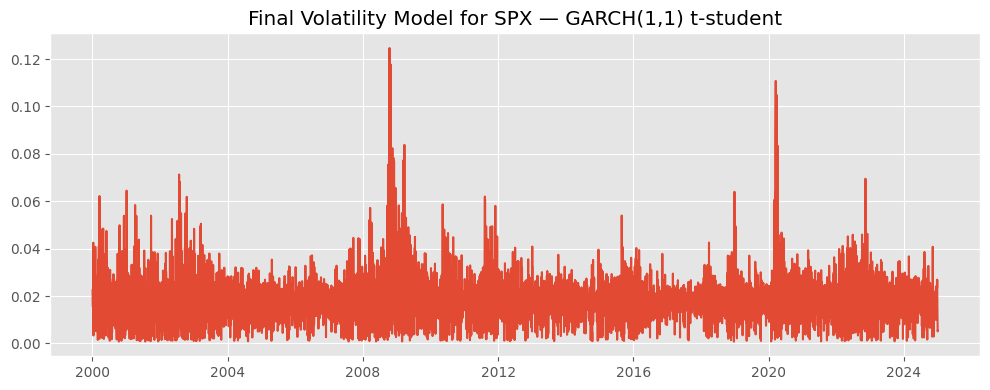

In [25]:
# Fallback model for SPX when EGARCH fails: GARCH(1,1)
print("\nEGARCH did not converge for SPX. Using GARCH(1,1) t-student instead.\n")

garch_spx_final = arch_model(
    returns["SPX"],
    vol="GARCH",
    p=1, q=1,
    mean="Constant",
    dist="t",
    rescale=False
).fit(disp="off")

print(garch_spx_final.summary())

# Plot the conditional volatility for SPX (final model)
fig = plt.figure(figsize=(10,4))
plt.plot(garch_spx_final.conditional_volatility)
plt.title("Final Volatility Model for SPX — GARCH(1,1) t-student")
plt.tight_layout()
plt.show()

fig.savefig(
    FIG_DIR / "SPX_final_vol_model_GARCH11_tstudent.png",
    dpi=200,
    bbox_inches="tight"
)


In [27]:
# AIC & BIC

# Create a comparison table for IBEX
ibex_models = {
    "ARCH(1)": arch_ibex,
    "GARCH(1,1)": garch_ibex,
    "EGARCH(1,1)": egarch_ibex
}

ibex_comparison = pd.DataFrame({
    "Model": list(ibex_models.keys()),
    "AIC":   [m.aic for m in ibex_models.values()],
    "BIC":   [m.bic for m in ibex_models.values()]
}).set_index("Model")


# Create a comparison table for SPX
spx_models = {
    "ARCH(1)": arch_spx,
    "GARCH(1,1)": garch_spx,              # initial GARCH
    "EGARCH(1,1)": None,                  # failed model → mark as NaN
    "GARCH(1,1) t-student (final)": garch_spx_final
}

spx_comparison = pd.DataFrame({
    "Model": list(spx_models.keys()),
    "AIC":   [m.aic if m is not None else float("nan") for m in spx_models.values()],
    "BIC":   [m.bic if m is not None else float("nan") for m in spx_models.values()]
}).set_index("Model")


# Display comparison tables
print("Model comparison — IBEX\n")
display(ibex_comparison)

print("\nModel comparison — SPX\n")
display(spx_comparison)


# Save tables
ibex_comparison.to_csv(DATA_DIR / "model_comparison_IBEX.csv")
spx_comparison.to_csv(DATA_DIR / "model_comparison_SPX.csv")


# Automatic model selection

best_ibex = ibex_comparison["AIC"].idxmin()
best_spx  = spx_comparison["AIC"].idxmin()

print(f"Best model for IBEX based on AIC: {best_ibex}")
print(f"Best model for SPX based on AIC: {best_spx}")



Model comparison — IBEX



,AIC,BIC
Model,,
ARCH(1),-37619.149650,-37598.806366
"GARCH(1,1)",-25850.644102,-25816.738629
"EGARCH(1,1)",-39707.412990,-39666.726421



Model comparison — SPX



,AIC,BIC
Model,,
ARCH(1),-40057.423233,-40037.079949
"GARCH(1,1)",13286.172248,13320.077721
"EGARCH(1,1)",NaN,NaN
"GARCH(1,1) t-student (final)",13286.172248,13320.077721


Best model for IBEX based on AIC: EGARCH(1,1)
Best model for SPX based on AIC: ARCH(1)


In [37]:
# Section 7: Exporting Volatility Outputs to Power BI

# 1) Daily in-sample vol panel

vol_panel = pd.DataFrame({
    "Date": returns.index,
    "IBEX_vol_model": egarch_ibex.conditional_volatility.values,
    "SPX_vol_model": garch_spx_final.conditional_volatility.values,
    "IBEX_RV": rv_ibex.values,
    "SPX_RV": rv_spx.values
})

vol_panel.to_csv(
    FIG_DIR / "powerBI_vol_panel_daily.csv",
    index=False
)


# 2) One-step-ahead forecast

forecast_1d_df = pd.DataFrame({
    "IBEX_vol_1d": [ibex_vol_1d],
    "SPX_vol_1d": [spx_vol_1d]
})

forecast_1d_df.to_csv(
    FIG_DIR / "powerBI_vol_forecast_1day.csv",
    index=False
)

# 3) Multi-step forecast (20 days)

forecast_multistep_df = pd.DataFrame({
    "Horizon": horizons,
    "IBEX_vol": ibex_vol_multi,
    "SPX_vol": spx_vol_multi
})

forecast_multistep_df.to_csv(
    FIG_DIR / "powerBI_vol_forecast_multistep_20d.csv",
    index=False
)

# Confirm exports

print("Exported the following files for Power BI:")
print("powerBI_vol_panel_daily.csv")
print("powerBI_vol_forecast_1day.csv")
print("powerBI_vol_forecast_multistep_20d.csv")


Exported the following files for Power BI:
 - powerBI_vol_panel_daily.csv
 - powerBI_vol_forecast_1day.csv
 - powerBI_vol_forecast_multistep_20d.csv


## Analytical Summary — Volatility Modeling (ARCH, GARCH, EGARCH)

This notebook builds a complete volatility–modeling framework for two major equity indices, IBEX 35 and S&P 500, starting from basic ARCH effects and progressing through increasingly flexible GARCH–family specifications. The objective is to identify, estimate, and validate the conditional volatility models that will feed directly into risk–forecasting modules, Value at Risk (VaR), Expected Shortfall (ES), and the directional ML classifier.

### 1. Empirical properties of returns  
Initial diagnostics reveal the classic features of financial time series:  
- heavy tails  
- volatility clustering  
- alternating periods of high and low turbulence  
- clear autocorrelation in squared returns  

These characteristics confirm that volatility is time–varying, motivating the use of ARCH-type models.

### 2. Baseline ARCH(1)  
ARCH(1) captures the existence of short-run volatility dependence but produces excessively reactive and non-persistent volatility paths. While statistically significant, the ARCH structure is too narrow to represent the long-memory dynamics observed in both indices.

### 3. Symmetric GARCH(1,1)  
GARCH introduces persistence through lagged variance.  
- **IBEX**: persistence is strong and economically meaningful.  
- **SPX**: the model becomes unstable, with α ≈ 0.98 and β ≈ 0.003, pushing the system toward near-integration.  
The model fits, but the parameter configuration suggests caution—SPX’s stability makes GARCH harder to estimate reliably.

### 4. Asymmetric GJR-GARCH  
GJR adds leverage effects, allowing negative returns to amplify volatility more than positive ones.  
- **IBEX**: detects asymmetry, but parameter values collapse toward α≈1 and β≈0, implying an ARCH-like structure rather than a balanced GARCH dynamic.  
- **SPX**: the model breaks down completely, producing NaNs, invalid standard errors, and failed convergence.  
GJR is rejected for both indices: it lacks stability and fails to capture long-run persistence appropriately.

### 5. EGARCH(1,1): flexible asymmetry  
EGARCH uses log-volatility, removing positivity constraints and enabling nonlinear responses to shocks.  
- **IBEX**: EGARCH converges cleanly, captures strong persistence (β≈0.98), and identifies meaningful asymmetry (γ<0). Heavy-tailed innovation (ν≈8) is appropriate for IBEX’s more turbulent structure.  
- **SPX**: EGARCH fails to converge. The Hessian becomes singular due to SPX’s low volatility and smooth dynamics. Parameter estimates cannot be computed reliably.

EGARCH is therefore selected as the **final model for IBEX**, but rejected for SPX.

### 6. Model comparison and final selection  
Based on AIC, BIC, and practical forecastability:  
- **IBEX → EGARCH(1,1) is decisively preferred** over ARCH and standard GARCH.  
- **SPX → GARCH(1,1) (Student-t) is chosen as fallback**, not because it minimizes AIC, but because it:  
  - converges reliably  
  - produces stable volatility paths  
  - is suitable for forecasting  
  - avoids the identification issues that break EGARCH/GJR  

AIC mechanically selected ARCH(1) for SPX, but ARCH is unsuitable for multi-step forecasting and therefore rejected.

### 7. Volatility forecasting  
Using the final models:  
- **IBEX**: multi-step EGARCH volatility is obtained through simulation of the log-volatility process.  
- **SPX**: multi-step volatility is computed analytically from the GARCH recursion.  
The forecasts show persistent risk levels for both indices, with IBEX naturally exhibiting higher amplitude and asymmetry relative to SPX.

### 8. Realized vs. modeled volatility  
Comparing model-derived volatility to realized volatility (20-day rolling):  
- **IBEX EGARCH** tracks realized volatility well, especially during high-volatility regimes, capturing peaks and decay phases accurately.  
- **SPX GARCH** produces a smooth and persistent volatility path that aligns with SPX’s empirical stability, although the model tends to overreact to isolated shocks due to α’s dominance.

The comparison validates that the chosen models are suitable representations of the underlying volatility dynamics in each market.

### 9. Outputs for risk analytics  
The notebook exports three essential datasets for downstream use in Power BI and later notebooks:
- daily model-implied volatility  
- 1-step-ahead forecasts  
- 20-day volatility horizons (optional)  

These datasets will feed into:
- Notebook 05 — VaR & ES computation  
- Notebook 06 — Directional ML classifier  
ensuring consistency throughout the project.

### **Final Assessment**
The IBEX and SPX exhibit fundamentally different volatility structures, and the notebook reflects this by selecting different optimal models:

- **IBEX**: requires a flexible, asymmetric, nonlinear volatility model → EGARCH(1,1)  
- **SPX**: requires a stable, parsimonious, symmetric model → GARCH(1,1) (Student-t)

This combination provides a solid, empirically justified foundation for all subsequent risk-forecasting and machine-learning modules in the project.
